In [42]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve



In [43]:
#################################
##         Gather Data         ##
#################################
Data = pd.read_csv('ai4i2020.csv')
df = pd.DataFrame(Data)
df


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [44]:
#################################
##         EXPLORE DATA        ##
#################################
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
Product ID
M14860    1
L53850    1
L53843    1
L53844    1
L53845    1
         ..
M18193    1
M18194    1
L50515    1
L50516    1
M24859    1
Name: count, Length: 10000, dtype: int64
UDI
1        1
6671     1
6664     1
6665     1
6666     1
        ..
3334     1
3335     1
3336     1
3337     1
10000    1
Name: count, Length: 10000, dtype: int64


array([[<Axes: title={'center': 'UDI'}>,
        <Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'Machine failure'}>,
        <Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>],
       [<Axes: title={'center': 'PWF'}>, <Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'RNF'}>]], dtype=object)

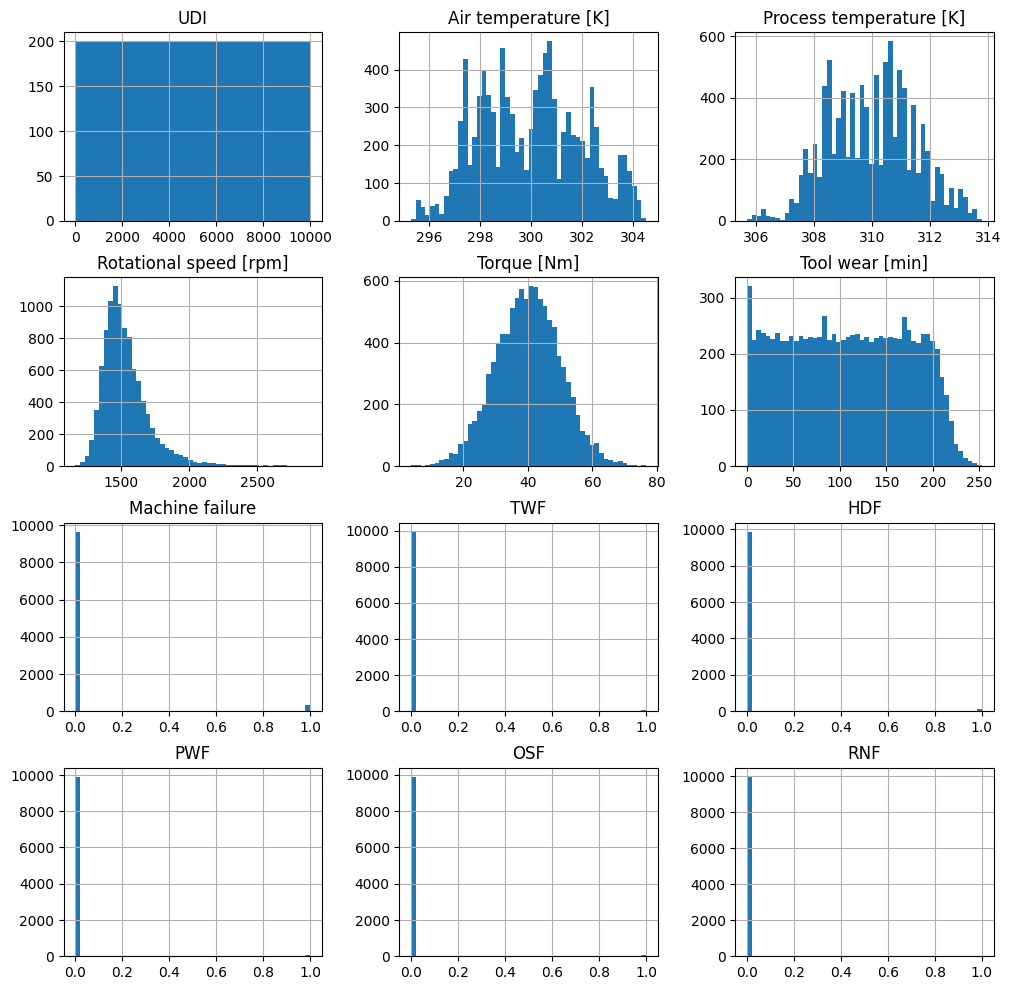

In [45]:
print(df['Type'].value_counts())
print(df['Product ID'].value_counts())
print(df['UDI'].value_counts())
#df.describe()

df.hist(bins=50, figsize=(12,12))


Type                       1.000000
Temp Differece             0.012867
Torque [Nm]               -0.003097
Rotational speed [rpm]    -0.003979
Power                     -0.004784
Tool wear [min]           -0.007255
Wear / Speed              -0.007766
Process temperature [K]   -0.012101
Air temperature [K]       -0.015176
Name: Type, dtype: float64


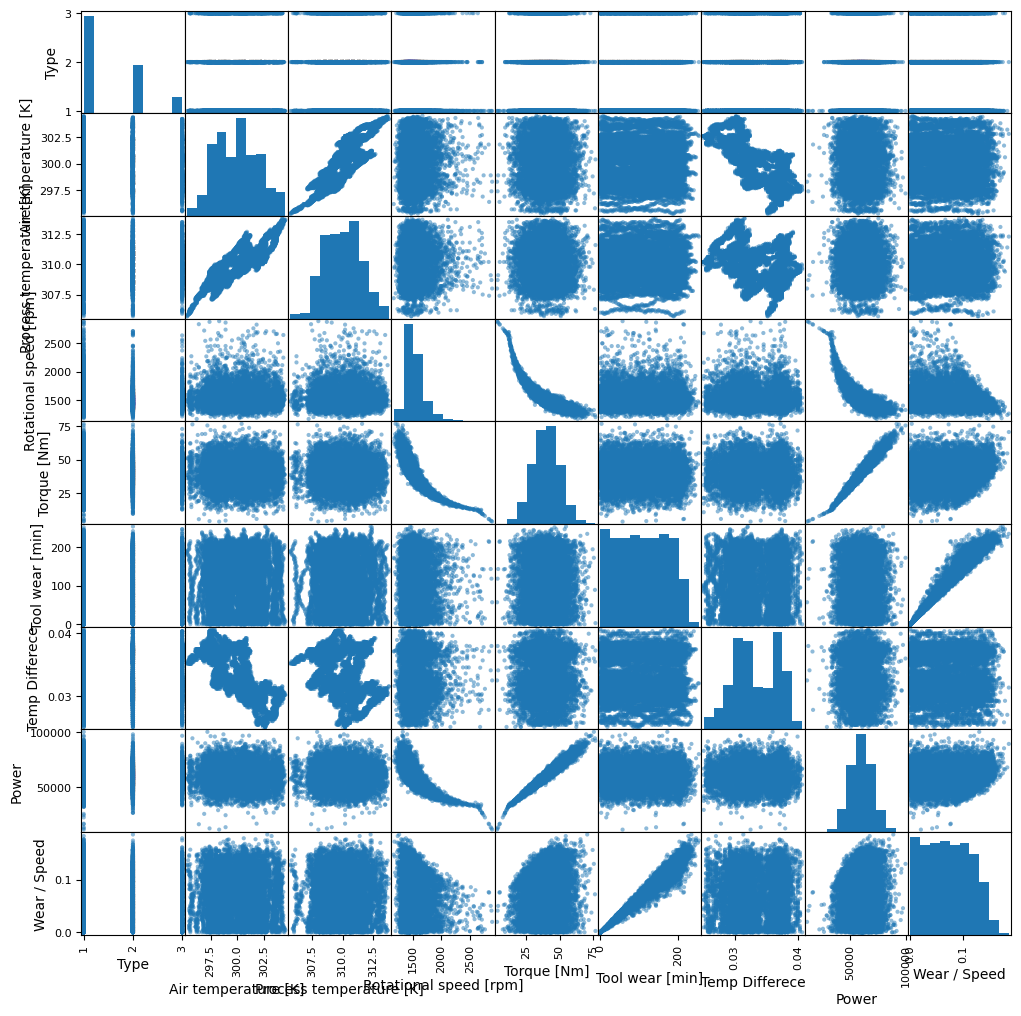

In [46]:
#################################
##         PREPARE DATA        ##
#################################
# 1. Handle missing or zero values
df = df.dropna()

# 2. Separate features (X) and target variable (y)
df['Type'] = df['Type'].map({'L': 1, 'M': 2, 'H': 3})
X = df.drop(columns = ['UDI', 'Product ID','Machine failure', 'PWF', 'TWF', 'HDF', 'OSF','RNF'])
Y = df['Machine failure']



# -- Detour --
machineFailure = X.copy()


# New features to look at based on correlation
machineFailure["Temp Differece"] = (machineFailure["Process temperature [K]"] - machineFailure["Air temperature [K]"])/machineFailure["Air temperature [K]"]
machineFailure["Power"] = machineFailure["Torque [Nm]"] * machineFailure["Rotational speed [rpm]"]
machineFailure["Wear / Speed"] = machineFailure["Tool wear [min]"] / machineFailure["Rotational speed [rpm]"]

# Correlation matrix
corrMatrix = machineFailure.corr()
corr = corrMatrix["Type"].sort_values(ascending=False)
print(corr)


scatter_matrix(machineFailure, figsize=(12,12))

# 3. Split the data
x_train, x_test, y_train, y_test = train_test_split(machineFailure, Y, train_size=0.8, stratify=Y, random_state=42)

# 4: Scale the features
scaler = StandardScaler()

# 5: Fit the scaler to the training data and transform both training and test sets
x_train_scaled = scaler.fit_transform(x_train)  # Scale the training set
x_test_scaled = scaler.transform(x_test)        # Scale the test set using the same scaler

In [47]:
###################################
##         TRAIN LR MODEL        ##
###################################

# 1. Create a logistic regression model
lr = LogisticRegression(random_state=42)

# 2. Train the model
lr.fit(x_train_scaled, y_train)

# 3. Make predictions
lr_y_pred_test = lr.predict(x_test_scaled)


In [48]:
###################################
##         TRAIN RF MODEL        ##
###################################

# 1. Create a random forrest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model
rf.fit(x_train_scaled, y_train)

# 2. Make predictions
rf_y_pred_test = rf.predict(x_test_scaled)

LR accuracy:  0.9675
RF accuracy:  0.9915
LR Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.57      0.18      0.27        68

    accuracy                           0.97      2000
   macro avg       0.77      0.59      0.63      2000
weighted avg       0.96      0.97      0.96      2000

RF Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.95      0.79      0.86        68

    accuracy                           0.99      2000
   macro avg       0.97      0.90      0.93      2000
weighted avg       0.99      0.99      0.99      2000



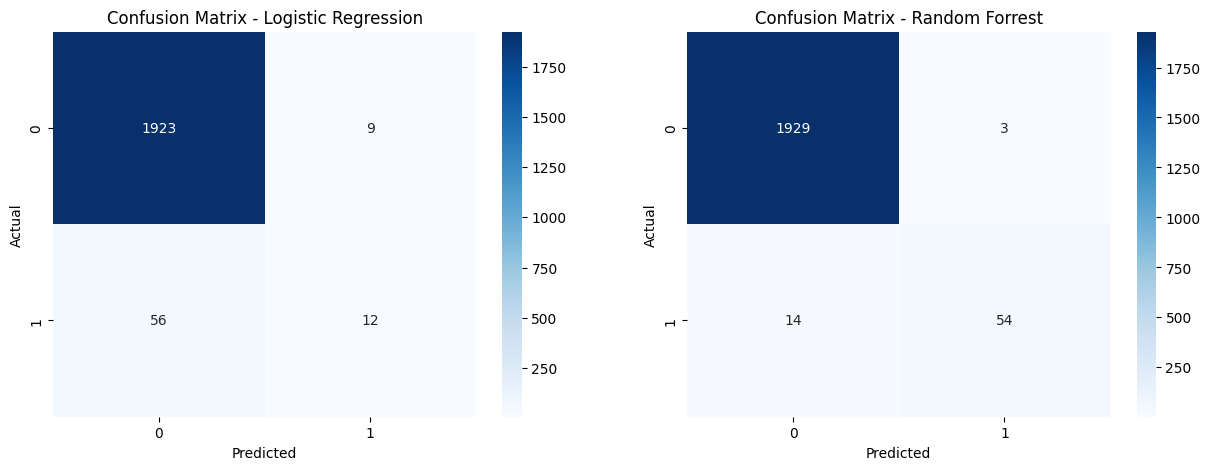

In [49]:
###################################
##         EVALUATE MODEL        ##
###################################

# 1. Calculate accuracy
lr_accuracy = accuracy_score(lr_y_pred_test, y_test)
rf_accuracy = accuracy_score(rf_y_pred_test, y_test)
print('LR accuracy: ', lr_accuracy)
print('RF accuracy: ', rf_accuracy)

# 2. Generate confusion matrix
lr_cm = confusion_matrix(y_test, lr_y_pred_test)
rf_cm = confusion_matrix(y_test, rf_y_pred_test)

# 3. Print classification report
print("LR Classification Report:")
print(classification_report(y_test, lr_y_pred_test))
print("RF Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

# 4. Visualize confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1,2,2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forrest')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

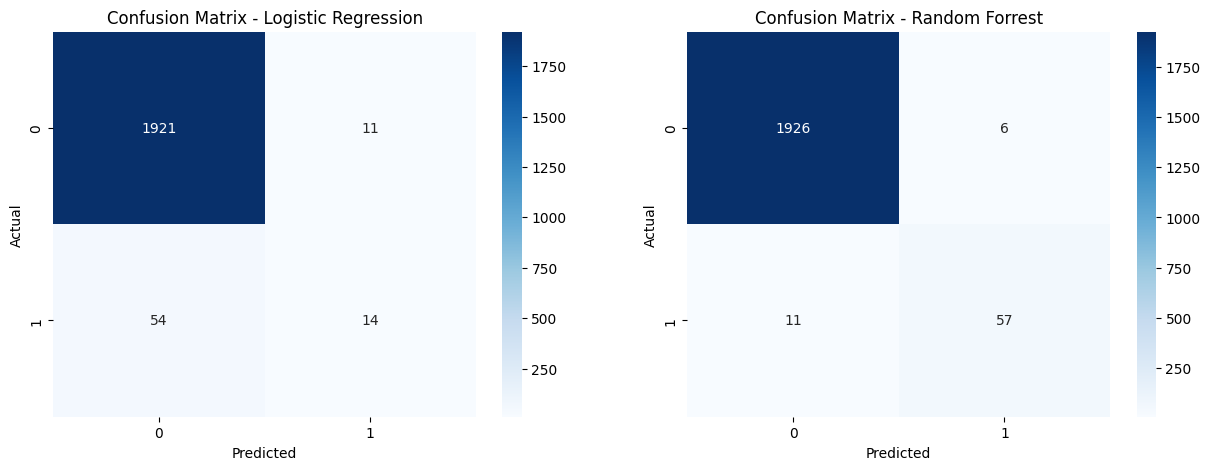

LR Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1932
           1       0.56      0.21      0.30        68

    accuracy                           0.97      2000
   macro avg       0.77      0.60      0.64      2000
weighted avg       0.96      0.97      0.96      2000

RF Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.90      0.84      0.87        68

    accuracy                           0.99      2000
   macro avg       0.95      0.92      0.93      2000
weighted avg       0.99      0.99      0.99      2000



In [50]:
#####################################
##         FINE-TUNE MODELS        ##
#####################################

threshold = 0.4  # Adjust threshold here
lr_y_prob_test = lr.predict_proba(x_test_scaled)[:, 1]
lr_y_pred_test = (lr_y_prob_test >= threshold).astype(int)

rf_y_prob_test = rf.predict_proba(x_test_scaled)[:, 1]
rf_y_pred_test = (rf_y_prob_test >= threshold).astype(int)

lr_cm = confusion_matrix(y_test, lr_y_pred_test)
rf_cm = confusion_matrix(y_test, rf_y_pred_test)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,2,2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forrest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# The classification report is printed again:
print("LR Classification Report:")
print(classification_report(y_test, lr_y_pred_test))
print("RF Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

In [51]:
# Hyper Parameter Tuning for Logistic Regression

# Parameters
# lr_param_grid = {
#     'C': [ 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
#     'solver': ['liblinear', 'saga'],  # Solver, afhængig af penalty
# }

# # Setup GridSearchCV
# lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
# lr_grid_search.fit(x_train_scaled, y_train)

# # Bedste model og hyperparametre
# print("Best Logistic Regression Params:", lr_grid_search.best_params_) 
# lr_best = lr_grid_search.best_estimator_

# RESULT #
# Best Logistic Regression Params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [52]:
# Hyper Parameter Tuning for Random Forrest

# rf_param_grid = {
#     'n_estimators': [100, 200, 300],  # Antal træer
#     'max_depth': [5, 10, 20, None],  # Maksimal dybde
#     'min_samples_split': [2, 5, 10],  # Minimum samples per split
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples per blad
#     'max_features': ['sqrt', 'log2'],  # Features per split
# }

# # Setup GridSearchCV
# rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
# rf_grid_search.fit(x_train_scaled, y_train)

# # Bedste model og hyperparametre
# print("Best Random Forest Params:", rf_grid_search.best_params_)
# rf_best = rf_grid_search.best_estimator_
#Best Random Forest Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


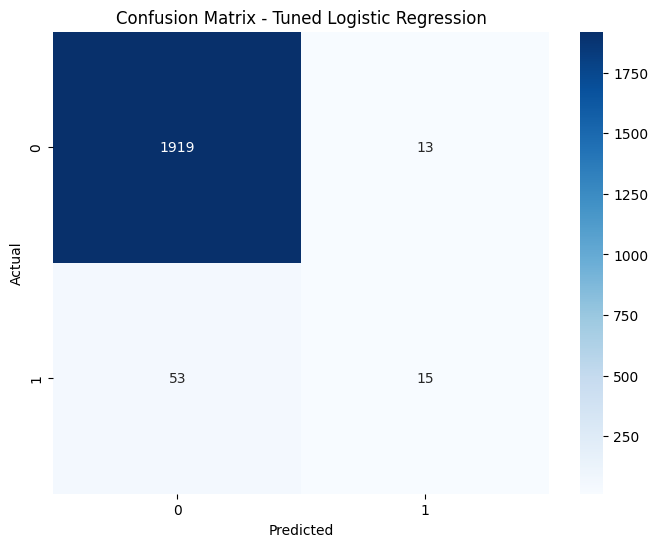

Classification Report - Tuned Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1932
           1       0.54      0.22      0.31        68

    accuracy                           0.97      2000
   macro avg       0.75      0.61      0.65      2000
weighted avg       0.96      0.97      0.96      2000



In [53]:
# Results New parameters - LR
lr_best = LogisticRegression(C=1, penalty='l1', solver='saga', random_state=42, max_iter=1000)

# Træn modellen på det skalerede træningsdatasæt
lr_best.fit(x_train_scaled, y_train)

# Evaluer modellen på testdatasættet
lr_y_prob_test = lr_best.predict_proba(x_test_scaled)[:, 1]
lr_y_pred_test = (lr_y_prob_test >= 0.4).astype(int)  # Threshold kan justeres

lr_cm = confusion_matrix(y_test, lr_y_pred_test)

# Visualiser confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print classification report
print("Classification Report - Tuned Logistic Regression:")
print(classification_report(y_test, lr_y_pred_test))

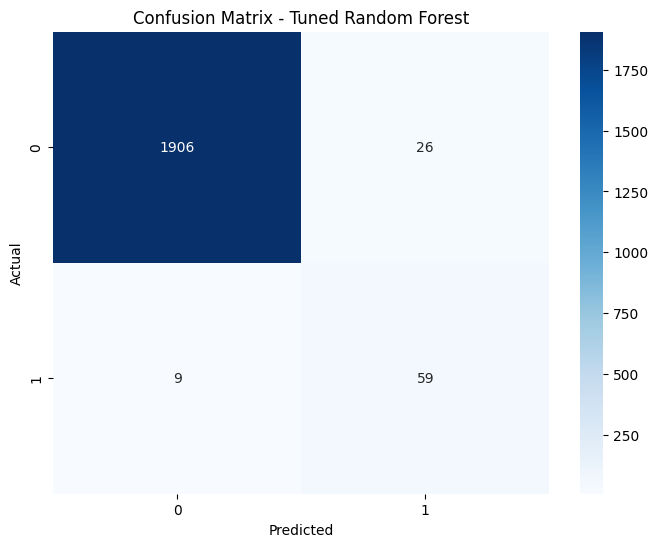

Classification Report - Tuned Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1932
           1       0.69      0.87      0.77        68

    accuracy                           0.98      2000
   macro avg       0.84      0.93      0.88      2000
weighted avg       0.99      0.98      0.98      2000



In [60]:
from sklearn.model_selection import cross_validate

# Results Random Forrest
rf_best = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    max_features='log2', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    random_state=42
)

# Træn modellen på træningsdatasættet
rf_best.fit(x_train_scaled, y_train)


# Evaluer modellen på testdatasættet
rf_y_prob_test = rf_best.predict_proba(x_test_scaled)[:, 1]
rf_y_pred_test = (rf_y_prob_test >= 0.2).astype(int)  # Threshold kan justeres

rf_cm = confusion_matrix(y_test, rf_y_pred_test)

# Visualiser confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



# Print classification report
print("Classification Report - Tuned Random Forest:")
print(classification_report(y_test, rf_y_pred_test))

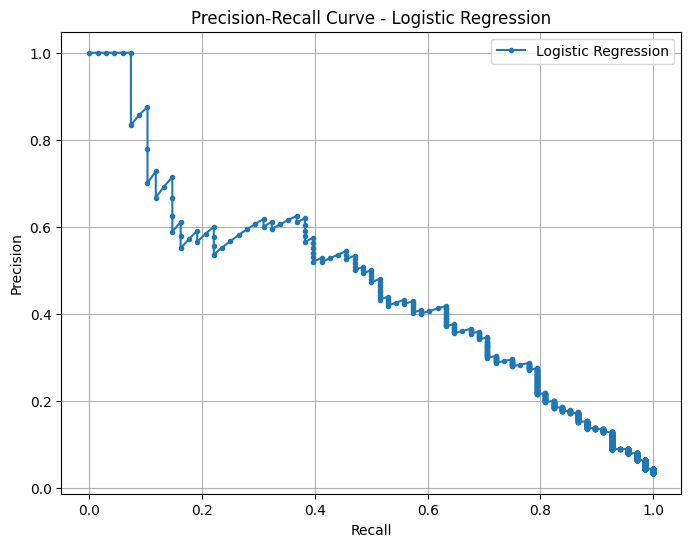

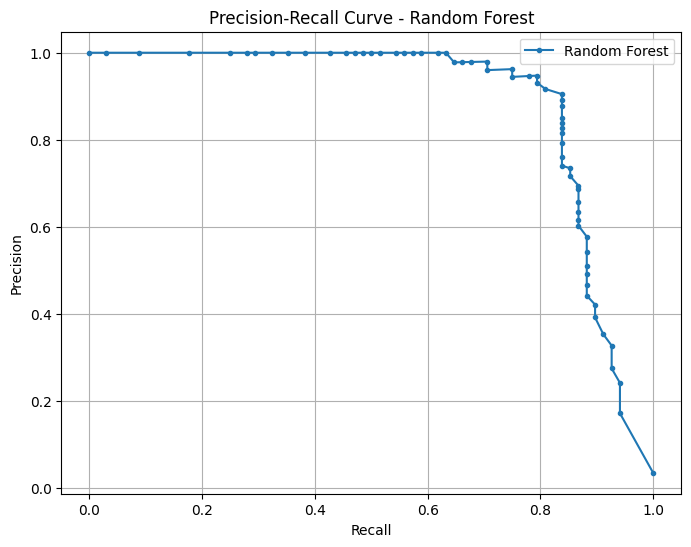

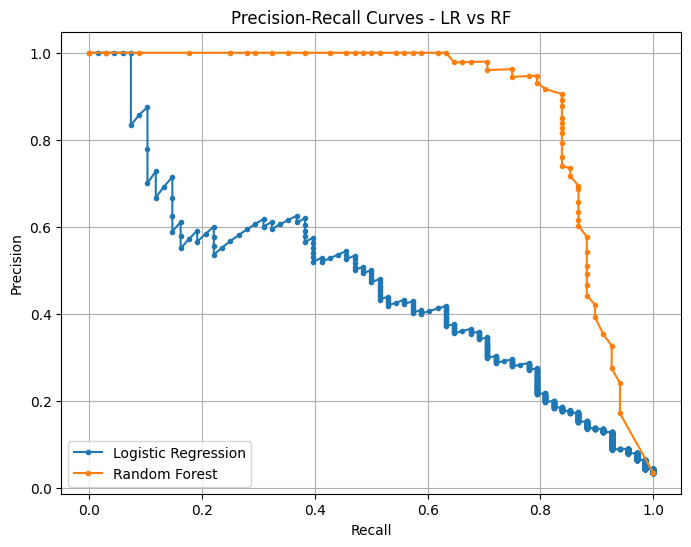

In [55]:
# Beregn præcision og recall for Logistic Regression
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, lr_best.predict_proba(x_test_scaled)[:, 1])


# Plot begge precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', label='Logistic Regression')
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest')

# Tilføj labels og titel
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - LR vs RF')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Feature importance
# This shows how much each feature contributes to the model's decisions
# feature_importance = rf.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, np.array(X.columns)[sorted_idx])
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance in Random Forest Model')
# plt.tight_layout()
# plt.show()

# # Print feature importance
# print("\nFeature Importance:")
# for i in sorted_idx:
#     print(f"{X.columns[i]}: {feature_importance[i]:.4f}")